## Results

 - y_max, window = 5, 
   - Test error: 87%
   - Train error: No vote 460, vote 390
 - y_max, window = 7, 
   - Test error: 88%
   - Train error: No vote 475, vote 403
   
 - y_max, window = 15, 
   - Test error: -
   - Train error: No vote 484, vote 429

In [10]:
%matplotlib inline

import collections
import heapq
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from hmmlearn.hmm import GaussianHMM, GMMHMM
from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection, grid_search
from sklearn.decomposition import TruncatedSVD
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from scipy import sparse as sp

## Import data

In [2]:
train_data = np.loadtxt('train.data', delimiter=',')
test_data = np.loadtxt('test.data', delimiter=',')

print train_data.shape
print test_data.shape

(4620L, 1079L)
(1540L, 1079L)


In [3]:
train_labels = np.loadtxt('train.labels', delimiter=',', skiprows=1)
print train_labels.shape

(4620L, 2L)


In [4]:
NUM_ROWS = 4620
NUM_TEST_ROWS = 1540
NUM_COLS = 1079
NUM_CLASSES = 7
POINTS_PER_CLASS = 660
NUM_COEFS = 13

## Analysis

(383460L, 13L)


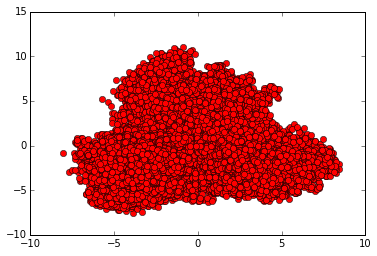

In [7]:
pca_model = decomposition.PCA(n_components=3)
transformed_data = np.array([train_data[j,i:i+13] for i in range(83) for j in range(4620)])
print transformed_data.shape
pca_data = pca_model.fit_transform(transformed_data)
plt.plot(pca_data[:,0], pca_data[:,1], 'ro')

In [14]:
print train_data[0,0:5]
print train_data[0,13:18]
print train_data[0,26:31]
print train_data[0,39:44]
print train_data[0,52:57]
print train_data[0,65:70]
print train_data[0,78:83]

[ 1.78802 -0.47844 -0.71328  0.17649  0.01343]
[ 1.25473 -1.48858 -1.12918  1.16447  0.599  ]
[ 1.44282 -1.75238 -1.64988  0.93129  0.61271]
[ 1.48252 -1.76708 -1.50098  0.95929  0.63889]
[ 0.64742 -1.24418 -1.22698  1.25686  0.65076]
[ -1.15000000e-03  -1.39608000e+00  -1.61188000e+00   1.18789000e+00
   4.12450000e-01]
[-0.37517 -1.94018 -1.64778  0.55852  0.51191]


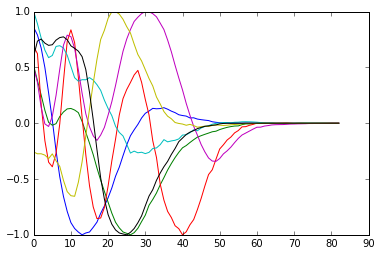

In [138]:
# Contenders: 2
COEF = 0
plt.plot(subplots=True)
for j in range(NUM_CLASSES):
    class_coef_avgs = [np.average(train_data[POINTS_PER_CLASS*j:POINTS_PER_CLASS*(j+1),COEF+13*i]) for i in range(83)]
    max_num = max(abs(i) for i in class_coef_avgs)
    plt.plot(range(83), [i / max_num for i in class_coef_avgs]) 
    #plt.plot(range(83), [np.std(train_data[POINTS_PER_CLASS*j:POINTS_PER_CLASS*(j+1),COEF+13*i]) for i in range(83)]) 

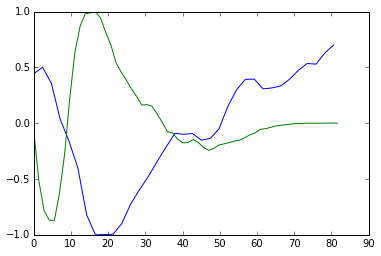

In [259]:
test_point = 662
test_classes = [6]
COEF = 5
window = 5

point_l = [train_data[test_point,COEF+13*i] for i in range(83)]
point_l = point_l[:point_l.index(0.0)]
avg_l = [np.average(point_l[i:min(i+window, len(point_l))]) for i in range(len(point_l))]
point_l = avg_l
max_p = max(abs(i) for i in point_l)
point_l_x = [i * 83.0 / len(point_l) for i in range(len(point_l))]
point_l_y =  [i/max_p for i in point_l]
plt.plot(point_l_x, point_l_y) 

for j in test_classes:
    
    class_coef_avgs = [np.average(train_data[POINTS_PER_CLASS*j:POINTS_PER_CLASS*(j+1),COEF+13*i]) for i in range(83)]
    class_coef_avgs = class_coef_avgs[:60]
    max_num = max(abs(i) for i in class_coef_avgs)
    x = [i * 83.0 / 60 for i in range(60)]
    y = [i / max_num for i in class_coef_avgs]
    plt.plot(x, y) 

(array([   1.,    0.,    1.,    1.,    3.,    1.,  388.,   32.,   25.,
          28.,   22.,   22.,   21.,   22.,   15.,   18.,   22.,   13.,
           3.,    2.]),
 array([-3.57668 , -2.995085, -2.41349 , -1.831895, -1.2503  , -0.668705,
        -0.08711 ,  0.494485,  1.07608 ,  1.657675,  2.23927 ,  2.820865,
         3.40246 ,  3.984055,  4.56565 ,  5.147245,  5.72884 ,  6.310435,
         6.89203 ,  7.473625,  8.05522 ]),
 <a list of 20 Patch objects>)

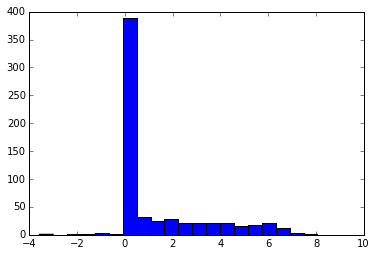

In [8]:
plt.hist(train_data[660:1300,500], bins = 20)
#plt.hist(train_data[POINTS_PER_CLASS*4:POINTS_PER_CLASS*5,100], bins = 20)

In [145]:
for j in range(NUM_CLASSES):
    avg = [np.average(train_data[660*j:660*(j+1),i]) for i in range(NUM_COLS)] 
    std = [np.std(train_data[660*j:660*(j+1),i]) for i in range(NUM_COLS)]
        
    avgs.append(avg)
    stds.append(std)
    
print len(avgs), len(avgs[0])
print len(stds), len(stds[0])

7 1079
7 1079


In [95]:
len(list(train_data[0,:]))

1079

35
52 806


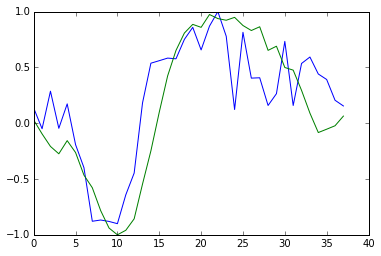

In [358]:
plt.plot(subplots=True)

ends = []
c = 5
c2 = 5
coef = 0
mult = 38
window = 1
l_thresh = 13 * (mult-window)
u_thresh = 13 * (mult+window)

ys = collections.defaultdict(int)
counter = 0
for row in range(POINTS_PER_CLASS*c,POINTS_PER_CLASS*(c+1)):
    
    l = list(train_data[row,:])
    j = 1
    for i in reversed(range(len(l))):
        if l[i] != 0:
            j = i+1
            break
    ends.append(j)
    
    if l_thresh < j < u_thresh:
        counter += 1
        for i in range(int(j / 13)):
            ys[i] +=  l[coef+13*i]
     
print counter    

for row in range(POINTS_PER_CLASS*c2,POINTS_PER_CLASS*(c2+1)):
    
    l = list(train_data[row,:])
    j = 1
    for i in reversed(range(len(l))):
        if l[i] != 0:
            j = i+1
            break
    ends.append(j)
    
    if l_thresh < j < u_thresh:
        #plt.plot(range(j), l[:j])
        jy =  [ l[coef+13*i] for i in range(mult)]
        max_jy = max([abs(y) for y in jy])
        jy = [y/max_jy for y in jy]
        plt.plot(range(mult), jy)
        
        yks = [ys[k]/counter for k in range(mult)]
        max_yk = max([abs(k) for k in yks])
        yks = [k/max_yk for k in yks]
        plt.plot(range(mult), yks)
        break
        
print min(ends), max(ends)
#plt.hist(ends, bins=50)

273 845


(array([  2.,   1.,   5.,   6.,  17.,  23.,  20.,  16.,   0.,  21.,  36.,
         34.,  49.,  50.,  31.,  34.,   0.,  52.,  54.,  41.,  33.,  19.,
         17.,  16.,   0.,  11.,  14.,  10.,   9.,   8.,   7.,   6.,   6.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   1.,
          3.,   1.,   1.,   0.,   0.,   1.]),
 array([ 21.  ,  21.88,  22.76,  23.64,  24.52,  25.4 ,  26.28,  27.16,
         28.04,  28.92,  29.8 ,  30.68,  31.56,  32.44,  33.32,  34.2 ,
         35.08,  35.96,  36.84,  37.72,  38.6 ,  39.48,  40.36,  41.24,
         42.12,  43.  ,  43.88,  44.76,  45.64,  46.52,  47.4 ,  48.28,
         49.16,  50.04,  50.92,  51.8 ,  52.68,  53.56,  54.44,  55.32,
         56.2 ,  57.08,  57.96,  58.84,  59.72,  60.6 ,  61.48,  62.36,
         63.24,  64.12,  65.  ]),
 <a list of 50 Patch objects>)

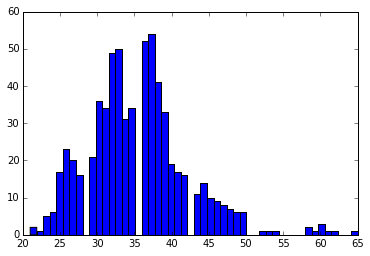

In [436]:
plt.plot(subplots=True)

ends = []
c = 3

ys = collections.defaultdict(int)
counter = 0
for row in range(POINTS_PER_CLASS*c,POINTS_PER_CLASS*(c+1)):
    
    l = list(train_data[row,:])
    j = 1
    for i in reversed(range(len(l))):
        if l[i] != 0.0:
            j = i+1
            break
    ends.append(j)
    
print min(ends), max(ends)
plt.hist([e / 13 for e in ends], bins=50)

## Build data structure

Dumping to JSON does not work :( Oh well

In [408]:
y_map = {}

min_elements = 5

for c in range(NUM_CLASSES):
    for speech_len in range(1,84):
        if speech_len % 10 == 0:
            print c, speech_len
        
        not_ready = True
        window = 1
        
        ys = None
        counter = 0
        while not_ready:
            
            counter = 0
            ys = collections.defaultdict(int)
            
            l_thresh = max(13 * (speech_len-window), 0)
            u_thresh = min(13 * (speech_len+window), 1079)
            
            for row in range(POINTS_PER_CLASS*c,POINTS_PER_CLASS*(c+1)):
                
                l = list(train_data[row,:])
                j = 1
                for i in reversed(range(len(l))):
                    if l[i] != 0:
                        j = i+1
                        break

                if l_thresh < j < u_thresh:
                    counter += 1
                    for i in range(j):
                        ys[i] +=  l[i]
            
            if counter > min_elements:
                not_ready = False
                break
            
            window += 1
        
        u_thresh = min(13 * (speech_len+window), 1079)
        yks = [ys[k]/counter for k in range(u_thresh)]
        max_yk = max([abs(k) for k in yks])
        yks = [k/max_yk for k in yks]
        
        y_map[ (c,speech_len) ] = yks
        
json.dump(y_map, open('y_map.json', 'w+'))

0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
2 10
2 20
2 30
2 40
2 50
2 60
2 70
2 80
3 10
3 20
3 30
3 40
3 50
3 60
3 70
3 80
4 10
4 20
4 30
4 40
4 50
4 60
4 70
4 80
5 10
5 20
5 30
5 40
5 50
5 60
5 70
5 80
6 10
6 20
6 30
6 40
6 50
6 60
6 70
6 80


TypeError: key (5, 31) is not a string

In [381]:
print len(y_map)

581


In [470]:
point = 672
mult = get_row_length(train_data[point,:]) / 13
print mult

39


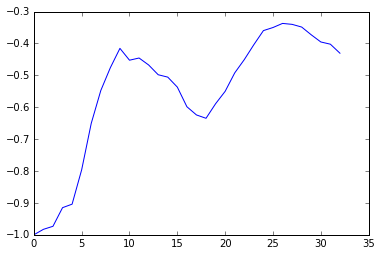

In [471]:
coef = 0
to_plot = train_data[point,:13*mult]

max_p = max(abs(p) for p in to_plot)
to_plot = [p / max_p for p in to_plot]

to_plot =  [ to_plot[coef+13*i] for i in range(mult)]
plt.plot(selected)


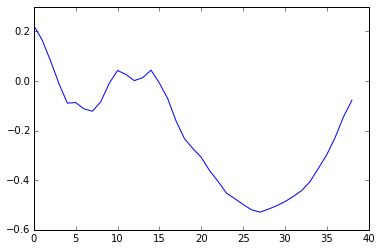

In [472]:
selected =  y_map[ (1,mult) ]
selected =  [ selected[coef+13*i] for i in range(mult)]
plt.plot(selected)

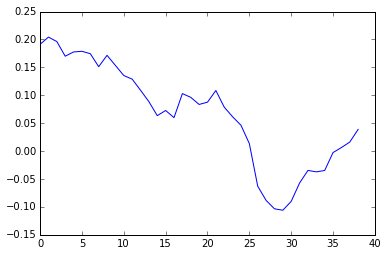

In [473]:
selected =  y_map[ (3,mult) ]
selected =  [ selected[coef+13*i] for i in range(mult)]
plt.plot(selected)

## System with no voting

In [440]:
def get_row_length(row):
    l = row
    j = 1
    for i in reversed(range(len(l))):
        if l[i] != 0:
            j = i+1
            break
    return j

In [442]:
errors = 0
errors_per_class = collections.defaultdict(int)

for test_row in range(NUM_ROWS):
        
    min_diff = float('inf')
    predicted_class = -1
    
    l = list(train_data[test_row,:])
    j = get_row_length(l)
    
    l = l[:j]
    max_l = max(abs(i) for i in l)
    l = [i/max_l for i in l]
    diffs = []

    for c in range(NUM_CLASSES):
        p =  y_map[ (c,j/13) ]
        diff = sum(abs(a-b) for a,b in zip(l,p))
        
        diffs.append(diff)
    
    actual_class = test_row / POINTS_PER_CLASS
    predicted_class = diffs.index(min(diffs))
    
    if actual_class != predicted_class:
        errors += 1
        errors_per_class[actual_class] += 1
        
print errors
for k in errors_per_class:
    print k, errors_per_class[k]

460
0 15
1 176
2 59
3 62
4 39
5 53
6 56


## Label test points (no voting)

In [398]:
f = open('1st.csv', 'w+')
f.write('Id,Prediction\n')
    
for test_row in range(NUM_TEST_ROWS):
        
    min_diff = float('inf')
    predicted_class = -1
    
    l = list(test_data[test_row,:])
    j = get_row_length(row)
    
    l = l[:j]
    max_l = max(abs(i) for i in l)
    l = [i/max_l for i in l]
    diffs = []

    for c in range(NUM_CLASSES):
        p =  y_map[ (c,j/13) ]
        diff = sum(abs(a-b) for a,b in zip(l,p))
        diffs.append(diff)
    
    predicted_class = diffs.index(min(diffs))
    
    f.write(str(test_row) + ',' + str(predicted_class) + '\n')
f.close()

## Method with voting

In [443]:
errors = 0
errors_per_class = collections.defaultdict(int)

for test_row in range(NUM_ROWS):
        
    min_diff = float('inf')
    predicted_class = -1
    
    l = list(train_data[test_row,:])
    j = get_row_length(l)
    
    l = l[:j]
    max_l = max(abs(i) for i in l)
    l = [i/max_l for i in l]
    
    mfcc_diffs = collections.defaultdict(list)

    for c in range(NUM_CLASSES):
        p =  y_map[ (c,j/13) ]
        diff = [abs(a-b) for a,b in zip(l,p)]
        
        for i in range(13):
            mfcc_diffs[i].append( (c, sum([diff[13*k+i] for k in range(j/13)])) )
            
    votes = []
    for k in mfcc_diffs:
        votes.append( min(mfcc_diffs[k], key=lambda t:t[1])[0] )
    
    actual_class = test_row / POINTS_PER_CLASS
    predicted_class = max(set(votes), key=votes.count)
    
    if actual_class != predicted_class:
        errors += 1
        errors_per_class[actual_class] += 1
        
print errors
for k in errors_per_class:
    print k, errors_per_class[k]

390
0 15
1 114
2 51
3 68
4 37
5 61
6 44


## Label test points (voting)

In [415]:
f = open('1st.csv', 'w+')
f.write('Id,Prediction\n')
    
for test_row in range(NUM_TEST_ROWS):
        
    min_diff = float('inf')
    predicted_class = -1
    
    l = list(test_data[test_row,:])
    j = get_row_length(l)
    
    l = l[:j]
    max_l = max(abs(i) for i in l)
    l = [i/max_l for i in l]
    
    mfcc_diffs = collections.defaultdict(list)

    for c in range(NUM_CLASSES):
        p =  y_map[ (c,j/13) ]
        diff = [abs(a-b) for a,b in zip(l,p)]
        
        for i in range(13):
            mfcc_diffs[i].append( (c, sum([diff[13*k+i] for k in range(j/13)])) )
            
    votes = []
    for k in mfcc_diffs:
        votes.append( min(mfcc_diffs[k], key=lambda t:t[1])[0] )
    
    predicted_class = max(set(votes), key=votes.count)
    
    f.write(str(test_row) + ',' + str(predicted_class) + '\n')
f.close()

## Test point distribution

[0, 13, 4, 11, 2, 0, 0]
30
1540


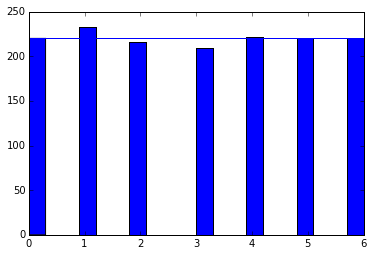

In [523]:
header = True
labels = []
for row in open('knn_1.csv'):
    if header:
        header = False
        continue
        
    labels.append(int(row.strip().split(',')[-1]))
    
plt.hist(labels, bins = 20)
avg = NUM_TEST_ROWS / NUM_CLASSES
plt.axhline(avg)

errors = []
for i in range(NUM_CLASSES):
    errors.append(abs(avg - labels.count(i)))
print errors
print sum(errors)

print len(labels)

## Submission diff

In [514]:
n_diff = 0.0
for l1, l2 in zip(open('knn_1.csv'), open('sub1.csv')):
    if l1 != l2:
        n_diff += 1

print n_diff
print n_diff * 100 / 1540, '%'

189.0
12.2727272727 %


## Algo Analysis

114
0 12
3 76
4 3
5 6
6 17
[666, 672, 677, 683, 687, 704, 708, 710, 718, 723, 725, 728, 729, 736, 762, 769, 780, 793, 798, 805, 815, 817, 820, 821, 842, 875, 881, 888, 896, 900, 904, 910, 938, 939, 949, 951, 954, 981, 982, 983, 996, 1009, 1012, 1031, 1037, 1064, 1069, 1072, 1082, 1094, 1100, 1103, 1109, 1114, 1115, 1135, 1138, 1158, 1163, 1165, 1171, 1172, 1198, 1216, 1241, 1250, 1253, 1254, 1273, 1280, 1285, 1287, 1288, 1291, 1296, 1297]


(array([  2.,   3.,  25.,  70.,   7.,   2.,   3.,   1.,   0.,   1.]),
 array([ 19. ,  24.3,  29.6,  34.9,  40.2,  45.5,  50.8,  56.1,  61.4,
         66.7,  72. ]),
 <a list of 10 Patch objects>)

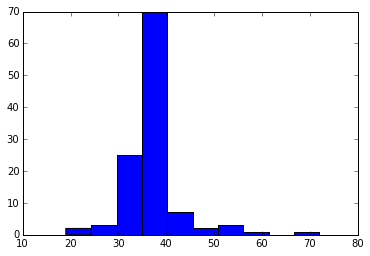

In [437]:
errors = 0
errors_per_class = collections.defaultdict(int)

incorrect_lengths = []
incorrect_class = collections.defaultdict(list)

for test_row in range(660, 660+660):
        
    min_diff = float('inf')
    predicted_class = -1
    
    l = list(train_data[test_row,:])
    j = 1
    for i in reversed(range(len(l))):
        if l[i] != 0:
            j = i+1
            break
    seq_length = j
    l = l[:j]
    max_l = max(abs(i) for i in l)
    l = [i/max_l for i in l]
    
    mfcc_diffs = collections.defaultdict(list)

    for c in range(NUM_CLASSES):
        p =  y_map[ (c,j/13) ]
        diff = [abs(a-b) for a,b in zip(l,p)]
        
        for i in range(13):
            mfcc_diffs[i].append( (c, sum([diff[13*k+i] for k in range(j/13)])) )
            
    votes = []
    for k in mfcc_diffs:
        votes.append( min(mfcc_diffs[k], key=lambda t:t[1])[0] )
    
    actual_class = test_row / POINTS_PER_CLASS
    predicted_class = max(set(votes), key=votes.count)
    
    if actual_class != predicted_class:
        errors += 1
        errors_per_class[actual_class] += 1
        incorrect_lengths.append(seq_length/13)
        incorrect_class[predicted_class].append(test_row)
        
print errors
for k in incorrect_class:
    print k, len(incorrect_class[k])
    
print incorrect_class[3]
    
    
plt.hist(incorrect_lengths)

## KNN

- k = 1: 28 errors
- k = 3: 46 errors

In [504]:
n_errors = 0
errors_per_class = collections.defaultdict(int)

k = 3

for row_num_1 in range(train_data.shape[0]):
    
    pred_class = -1
    h = []
    
    for row_num_2 in range(train_data.shape[0]):
        if row_num_1 != row_num_2:
            dist = np.linalg.norm(train_data[row_num_1,:] - train_data[row_num_2,:])
            dist = -dist
            
            if len(h) < k:
                heapq.heappush(h, (dist, row_num_2 / POINTS_PER_CLASS))
            elif dist > h[0][0]:
                heapq.heappop(h)
                heapq.heappush(h, (dist, row_num_2 / POINTS_PER_CLASS))
                
    actual_class = row_num_1 / POINTS_PER_CLASS
    
    votes = [t[1] for t in h]
    pred_class = max(set(votes), key=votes.count)
    
    if actual_class != pred_class:
        n_errors += 1
        errors_per_class[actual_class] += 1
        
print n_errors
for k in errors_per_class:
    print k, errors_per_class[k]

27
0 1
1 4
2 6
3 5
5 8
6 3


## KNN - Test Set

In [522]:
f = open('knn_1.csv', 'w+')
f.write('Id,Prediction\n')

k = 1

for row_num_1 in range(test_data.shape[0]):
    
    pred_class = -1
    h = []
    
    for row_num_2 in range(train_data.shape[0]):
        dist = np.linalg.norm(test_data[row_num_1,:] - train_data[row_num_2,:])
        dist = -dist

        if len(h) < k:
            heapq.heappush(h, (dist, row_num_2 / POINTS_PER_CLASS))
        elif dist > h[0][0]:
            heapq.heappop(h)
            heapq.heappush(h, (dist, row_num_2 / POINTS_PER_CLASS))
                
    
    votes = [t[1] for t in h]
    pred_class = max(set(votes), key=votes.count)
    
    f.write(str(row_num_1) + ',' + str(pred_class) + '\n')

f.close()

In [495]:
h = []
heapq.heappush(h, (-5, 'write code'))
print h[0]
heapq.heappush(h, (-7, 'release product'))
print h[0]
heapq.heappush(h, (-1, 'write spec'))
print h[0]
heapq.heappush(h, (-3, 'create tests'))
while len(h) > 0:
    print heapq.heappop(h)

(-5, 'write code')
(-7, 'release product')
(-7, 'release product')
(-7, 'release product')
(-5, 'write code')
(-3, 'create tests')
(-1, 'write spec')


## HMM

In [ ]:
for c in range(NUM_CLASSES):
    current_rows = train_data[POINTS_PER_CLASS*c:POINTS_PER_CLASS*(c+1),:]
    print current_rows.shape
    model = GMMHMM(n_components = 5)
    model.fit([current_rows]) 